# Importing Necessary libraries

In [58]:
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import optimizers
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.io as pio
#pip install split-folders
#pip install plotly
#pip install -U kaleido

In [59]:
from tensorflow.keras.layers import BatchNormalization

In [60]:
tf.__version__

'2.1.0'

In [61]:
keras.__version__
# with tensorflow backend

'2.2.4-tf'

# Dataset Preprocessing

### spliting folder to train, validation and test

In [11]:
# import splitfolders

In [13]:
# # split with a ratio 80% for training, 10%  for validation and 10% for testing
# #  

# input_folder = 'dataset'
# splitfolders.ratio(input_folder, output = 'dataset_final',
#                   seed = 42, ratio = (.7, .2, .1),
#                   group_prefix = None)

In [15]:
#checking input image shape 
image = cv2.imread('dataset_final/train/Tomato___healthy/0bfe260c-a71e-474e-bfb1-78f1e5ca5698___RS_HL 0497.JPG')
image.shape

(256, 256, 3)

### Building Convolutional layer

In [16]:
# Initialising the CNN
model = models.Sequential()

In [17]:
# # Step 1 - Convolution
model.add(layers.Conv2D(32,(3,3), activation = 'relu',
                        # 32 is the depth of 1st Conv Layer (number of filters)
                        # depth is typically the number of filter applied in order to extract the useful feature map
# with ReLU(Rectified Linear Unit) we introduce non linearity to our Conv network.
                       input_shape = (256,256,3))) 
                        # input_shape = resizes all input images to 128*128 pixels


In [18]:
# Step 2 - Pooling (sub sampling or down sampling)
# Pooling reduces the dimensionality of each rectified feature map but retains the most important information.
# since we have activated the layer with ReLU, we called it rectified feature map

model.add(MaxPooling2D(pool_size = (2, 2)))

# pooling with 2*2 spatial neighborhood which is called stride = 2
# stride is the number of pixel we move in each pooling step

In [19]:
# Adding a second convolutional layer and MaxPooling layer
# this second convolutional layer is obtained for 1st pooling layer
# that means the 1st pooling layer acts as a feature map for obtaining 2nd Conv layer
#this time we use 64 filters 
model.add(Conv2D(32, (3, 3), activation = 'relu'))

# again the pooling is done with the same process done above
model.add(MaxPooling2D(pool_size = (2, 2)))

In [20]:
# now we add two more Conv Layer and Pooling layer
# Adding a third convolutional layer  and MaxPooling layer
model.add(Conv2D(64, (3, 3), activation = 'relu'))



model.add(MaxPooling2D(pool_size = (2, 2)))

In [21]:
# Adding a fourth convolutional layer  and MaxPooling layer
model.add(Conv2D(64, (3, 3), activation = 'relu'))

model.add(MaxPooling2D(pool_size = (2, 2)))

In [22]:
# Adding a fifth convolutional layer  and MaxPooling layer
model.add(Conv2D(128, (3, 3), activation = 'relu'))

model.add(MaxPooling2D(pool_size = (2, 2)))

In [23]:
# Adding a sixth convolutional layer  and MaxPooling layer
model.add(Conv2D(128, (3, 3), activation = 'relu'))

model.add(MaxPooling2D(pool_size = (2, 2)))

In [24]:
# # Step 3 - Flattening
# # Flattening is converting the data into a 1-dimensional array for inputting it to the next layer.
model.add(Flatten())

###  Adding DropOut

In [25]:
# ## adding dropout layer right after the densely connected classifier
model.add((layers.Dropout(0.2)))

In [26]:
# Step 4 - Full connection (feed forward neural network)
model.add(Dense(512, activation = 'relu'))
model.add(Dense(6, activation = 'sigmoid'))

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 64)        3

In [28]:
# top_layer = model.layers[0]
# plt.imshow(top_layer.get_weights()[0][:,:,:,0].squeeze(), cmap = 'gray')
# plt.show()

In [30]:
# Compiling the CNN
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['acc'])


### Data-augmentation

In [31]:
#Using data-augmentation generators
train_datagen = ImageDataGenerator(rescale = 1./256,
                                  rotation_range=40,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True)

In [32]:
from tensorflow.keras.preprocessing import image

####  Augmented Images samples

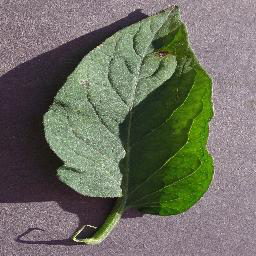

In [33]:
img = image.load_img('dataset_final/train/Tomato___Target_Spot/002213fb-b620-4593-b9ac-6a6cc119b100___Com.G_TgS_FL 8360.JPG')
img

In [34]:
x = image.img_to_array(img)

In [35]:
x = x.reshape((1,) + x.shape)

In [62]:
# i = 0
# for batch in train_datagen.flow(x, batch_size=1):
#     plt.figure(i)
#     imgplot = plt.imshow(image.array_to_img(batch[0]))
#     i += 1
#     if i % 4 == 0:
#         break
# plt.show()

In [37]:
img_width,img_height =256,256
input_shape=(img_width,img_height,3)
batch_size =128

# Training Preparation

In [38]:
test_datagen = ImageDataGenerator(rescale = 1./256)


In [39]:
train_generator = train_datagen.flow_from_directory('dataset_final/train',
                                                    target_size = (img_width,img_height),
                                                    batch_size = batch_size,
                                                    class_mode = 'categorical')

Found 7331 images belonging to 6 classes.


In [40]:
validation_generator = test_datagen.flow_from_directory('dataset_final/val',
                                                        target_size = (img_width,img_height),
                                                        batch_size = batch_size,
                                                        class_mode = 'categorical',
                                                        shuffle = False)

Found 2093 images belonging to 6 classes.


In [41]:
test_generator=test_datagen.flow_from_directory('dataset_final/test',
                                                shuffle=False,
                                                target_size=(img_width,img_height),
                                                class_mode = 'categorical')

Found 1054 images belonging to 6 classes.


In [42]:
train_generator.class_indices

{'Tomato___Bacterial_spot': 0,
 'Tomato___Late_blight': 1,
 'Tomato___Septoria_leaf_spot': 2,
 'Tomato___Spider_mites Two-spotted_spider_mite': 3,
 'Tomato___Target_Spot': 4,
 'Tomato___healthy': 5}

In [43]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (128, 256, 256, 3)
labels batch shape: (128,)


In [44]:
steps_per_epoch=train_generator.samples // batch_size
steps_per_epoch

57

## Add Callbacks

In [45]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 15, verbose = 1)
#patience = number of epochs with no improvement after which training will be stopped

In [46]:
log_csv = CSVLogger('my_logs_5.csv', separator = ',', append = False)

In [47]:
callback_list = [early_stop, log_csv]

In [48]:
opt=keras.optimizers.Adam(lr=0.001)
model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])

# Model training

In [49]:
train=model.fit_generator(train_generator,
                          epochs=100,
                          steps_per_epoch=train_generator.samples // batch_size,
                          # traditional approach
                          validation_data=validation_generator,
                          callbacks = callback_list,
                        verbose=1)


In [41]:
import os.path
if os.path.isfile('model_1.h5') is False:
    model.save('model_1.h5')

In [43]:
new_model = load_model('model_1.h5')
new_model.optimizer

# Plotting results

In [50]:
scores_df = pd.read_csv("my_logs.csv")
scores_df

In [51]:
loss_train = train.history['accuracy']
loss_val = train.history['val_accuracy']
epochs = range(1,21)
plt.figure(figsize = (8,6))
plt.grid(True)
plt.plot(epochs, loss_train, 'g', label='Training acc')
plt.plot(epochs, loss_val, 'b', label='Validation acc')
plt.ylim(0.5,1)
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
 
plt.show()

In [52]:
loss_train = train.history['loss']
loss_val = train.history['val_loss']
epochs = range(1,25)
plt.figure(figsize = (8,6))
plt.grid(True)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='Validation loss')
 
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
 
plt.show()

In [ ]:
# classification report

In [54]:
score,accuracy =model.evaluate(test_generator,verbose=1)
print("Test score is {}".format(score))
print("Test accuracy is {}".format(accuracy))

## Visualizing filters, Convolution layers and Pooling layers

## Filter

In [55]:
# #Iterate through all the layers of the model
# for layer in model.layers:
#     if 'conv' in layer.name:
#         weights, bias= layer.get_weights()
#         #print(layer.name, filters.shape)
        
#         #normalize filter values between  0 and 1 for visualization
#         f_min, f_max = weights.min(), weights.max()
#         filters = (weights - f_min) / (f_max - f_min)  
#         print(filters.shape[3])
#         filter_cnt=1
        
#         #plotting all the filters
#         for i in range(filters.shape[3]):
#             #get the filters
#             filt=filters[:,:,:, i]
#             #plotting each of the channel, color image RGB channels
#             for j in range(filters.shape[0]):
#                 #plt.figure(figsize=(12,8))
#                 ax= plt.subplot(filters.shape[3], filters.shape[0], filter_cnt)
#                 ax.set_xticks([])
#                 ax.set_yticks([])
#                 plt.imshow(filt[:,:, j])
#                 filter_cnt+=1
        
#         plt.show()


### Visualising convolutional layers and Pooling layers

In [56]:
# img_path='dataset_final/test/Tomato___healthy/02b4afdf-e1de-4c0e-a38d-3f19afeb9ea9___RS_HL 0493.JPG'  
# successive_outputs = [layer.output for layer in model.layers[1:]]
# visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)
# img = load_img(img_path, target_size=(256, 256)) 
# x   = img_to_array(img)                           # Numpy array with shape (150, 150, 3)
# x   = x.reshape((1,) + x.shape)  
# x /= 255.0
# successive_feature_maps = visualization_model.predict(x)
# layer_names = [layer.name for layer in model.layers]
# for layer_name, feature_map in zip(layer_names, successive_feature_maps):
#     #print(feature_map.shape)
#     if len(feature_map.shape) == 4:
#         n_features = feature_map.shape[-1]  # number of features in the feature map
#         size       = feature_map.shape[ 1]
#         display_grid = np.zeros((size, size * n_features))
#         for i in range(n_features):
#             x  = feature_map[0, :, :, i]
#             x -= x.mean()
#             x /= x.std ()
#             x *=  64
#             x += 128
#             x  = np.clip(x, 0, 255).astype('uint8')
#             display_grid[:, i * size : (i + 1) * size] = x
#         scale = 20. / n_features
#         plt.figure( figsize=(scale * n_features, scale) )
#         plt.title ( layer_name )
#         plt.grid  ( False )
#         plt.imshow( display_grid, aspect='auto', cmap='viridis' ) 


In [57]:
# img_path='dataset_final/train/Tomato___Target_Spot/01f0e0cb-83a7-4190-9645-bd06b70c8d65___Com.G_TgS_FL 8318.JPG' 
# successive_outputs = [layer.output for layer in model.layers[1:]]
# visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)
# img = load_img(img_path, target_size=(256, 256)) 
# x   = img_to_array(img)                           # Numpy array with shape (150, 150, 3)
# x   = x.reshape((1,) + x.shape)  
# x /= 255.0
# successive_feature_maps = visualization_model.predict(x)
# layer_names = [layer.name for layer in model.layers]
# for layer_name, feature_map in zip(layer_names, successive_feature_maps):
#     #print(feature_map.shape)
#     if len(feature_map.shape) == 4:
#         n_features = feature_map.shape[-1]  # number of features in the feature map
#         size       = feature_map.shape[ 1]
#         display_grid = np.zeros((size, size * n_features))
#         for i in range(n_features):
#             x  = feature_map[0, :, :, i]
#             x -= x.mean()
#             x /= x.std ()
#             x *=  64
#             x += 128
#             x  = np.clip(x, 0, 255).astype('uint8')
#             display_grid[:, i * size : (i + 1) * size] = x
#         scale = 20. / n_features
#         plt.figure( figsize=(scale * n_features, scale))
#         plt.title ( layer_name )
#         plt.grid  ( False )
#         plt.imshow( display_grid, aspect='auto', cmap='viridis' ) 
